In [47]:
from utils import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.classification import RandomForestClassifier, \
    DecisionTreeClassifier
from pyspark.ml.evaluation \
    import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [33]:
# Función para ensamblar características
def prepare_features(df, feature_columns, output_col='features'):
    assembler = VectorAssembler(inputCols=feature_columns,
        outputCol=output_col)
    return assembler.transform(df)

# Función para evaluar modelos
def evaluate_model(model, data, evaluator, metric_name='accuracy'):
    predictions = model.transform(data)
    return evaluator.evaluate(predictions, {evaluator.metricName: metric_name})

# Función para graficar resultados
def plot_results(data, labels, title, xlabel, ylabel, cmap='viridis'):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap=cmap, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [36]:
# Cargar los datos
df = load_data()
feature_columns = df.columns[:-1]
df_features = prepare_features(df, feature_columns)
df_features.show()

./data/datasetMta33featues.csv ya existe.
./data/datasetLeg33featues.csv ya existe.
+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+--------------------+------------------+--------------------+-------------------+-----+--------------------+
|         FinFlagDist|         SynFlagDist|        RstFlagDist|         PshFlagDist|         AckFlagDist|          DNSoverIP|          TCPoverIP|           UDPoverIP|              MaxLen|             MinLen

In [37]:
# Dividir en datos de entrenamiento y prueba
train_data, test_data = df_features.randomSplit([0.7, 0.3], seed=42)

In [38]:
# Evaluadores
multi_evaluator = MulticlassClassificationEvaluator(labelCol='label',
    predictionCol='prediction')
binary_evaluator = BinaryClassificationEvaluator(labelCol='label',
    rawPredictionCol='prediction')

In [45]:
# Modelo de árbol de decisión
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')

dt_model = dt.fit(train_data)

dt_accuracy = evaluate_model(dt_model, test_data, multi_evaluator)
print(f"Exactitud del modelo de árbol de decisión: {dt_accuracy:.2f}")

print("Árbol de decisión:\n", dt_model.toDebugString)

Exactitud del modelo de árbol de decisión: 0.97
Árbol de decisión:
 DecisionTreeClassificationModel: uid=DecisionTreeClassifier_52f8b605d6f3, depth=5, numNodes=25, numClasses=2, numFeatures=33
  If (feature 30 <= -1.6083028290909769)
   Predict: 0.0
  Else (feature 30 > -1.6083028290909769)
   If (feature 9 <= 1.2874249304201673)
    If (feature 17 <= 1.3523666409756177)
     If (feature 19 <= -0.7653922513542879)
      If (feature 30 <= 0.6118616748248638)
       Predict: 0.0
      Else (feature 30 > 0.6118616748248638)
       Predict: 1.0
     Else (feature 19 > -0.7653922513542879)
      If (feature 19 <= 1.62847486040521)
       Predict: 1.0
      Else (feature 19 > 1.62847486040521)
       Predict: 0.0
    Else (feature 17 > 1.3523666409756177)
     If (feature 7 <= 0.2124779900249632)
      If (feature 9 <= -0.4244184602398876)
       Predict: 0.0
      Else (feature 9 > -0.4244184602398876)
       Predict: 1.0
     Else (feature 7 > 0.2124779900249632)
      If (feature 14 <= -1

In [46]:
# AUC del modelo
roc_auc = evaluate_model(dt_model, test_data, binary_evaluator,
    metric_name='areaUnderROC')
print(f"AUC: {roc_auc:.2f}")

AUC: 0.97


In [ ]:
# Modelo de bosque aleatorio
rf = RandomForestClassifier(featuresCol='features', labelCol='label',
    numTrees=100)

rf_model = rf.fit(train_data)

rf_accuracy = evaluate_model(rf_model, test_data, multi_evaluator)
print(f"Exactitud del modelo Random Forest: {rf_accuracy:.2f}")

Exactitud del modelo Random Forest: 1.00


In [40]:
# Importancia de las características
print("Importancia de las características:")
for feature, importance in zip(feature_columns, rf_model.featureImportances):
    print(f"{feature}: {importance:.4f}")

Importancia de las características:
FinFlagDist: 0.0523
SynFlagDist: 0.0018
RstFlagDist: 0.0032
PshFlagDist: 0.0012
AckFlagDist: 0.0155
DNSoverIP: 0.0018
TCPoverIP: 0.0034
UDPoverIP: 0.0056
MaxLen: 0.0232
MinLen: 0.1068
StdDevLen: 0.0057
AvgLen: 0.0157
MaxIAT: 0.0320
MinIAT: 0.0110
AvgIAT: 0.0147
AvgWinFlow: 0.0035
PktsIOratio: 0.0083
1stPktLen: 0.1752
MaxLenrx: 0.0032
MinLenrx: 0.1732
StdDevLenrx: 0.0016
AvgLenrx: 0.0077
MinIATrx: 0.0174
AvgIATrx: 0.0014
NumPorts: 0.0018
FlowLEN: 0.0097
FlowLENrx: 0.0051
repeated_pkts_ratio: 0.0159
NumCon: 0.0082
NumIPdst: 0.0057
Start_flow: 0.2399
DeltaTimeFlow: 0.0268
HTTPpkts: 0.0018


In [41]:
# Matriz de correlación
correlation_matrix = Correlation.corr(df_features,
    "features").head()[0].toArray()

correlation_df = pd.DataFrame(correlation_matrix,
    columns=feature_columns, index=feature_columns)

print("Matriz de correlación:\n", correlation_df)

Matriz de correlación:
                      FinFlagDist  SynFlagDist  RstFlagDist  PshFlagDist  \
FinFlagDist             1.000000     0.819528    -0.208695     0.635939   
SynFlagDist             0.819528     1.000000    -0.274743     0.774576   
RstFlagDist            -0.208695    -0.274743     1.000000    -0.313686   
PshFlagDist             0.635939     0.774576    -0.313686     1.000000   
AckFlagDist             0.697103     0.812633    -0.286266     0.931966   
DNSoverIP               0.164405     0.223863     0.158831     0.127329   
TCPoverIP              -0.118135    -0.174354    -0.141458    -0.090858   
UDPoverIP               0.127132     0.186744     0.146963     0.100309   
MaxLen                  0.523069     0.666485    -0.443542     0.798156   
MinLen                 -0.273353    -0.249195    -0.010274    -0.206378   
StdDevLen               0.483613     0.597880    -0.459849     0.693197   
AvgLen                  0.367549     0.518749    -0.453969     0.778456   
M

In [42]:
# Agrupamiento con k medias bisectantes
bkm = BisectingKMeans(k=3, featuresCol='features', maxIter=10)

bkm_model = bkm.fit(df_features)
bkm_predictions = bkm_model.transform(df_features)

print("Centroides de Bisecting K-Means:", bkm_model.clusterCenters())

Centroides de Bisecting K-Means: [array([-0.92495601, -1.16504595,  0.78466991, -1.23496041, -1.21855823,
       -0.14365375,  0.14814293, -0.15660003, -1.36690031,  0.39829535,
       -1.2432527 , -1.18454165, -0.90673579,  0.26007049, -0.55554397,
        1.11377291,  0.56564846, -0.27854407, -1.28648823,  0.61117652,
       -0.80015729, -0.78791924,  0.38607285, -0.4067952 , -0.67919112,
       -1.2833282 , -0.10817851,  1.07443369, -0.18912317, -0.18823467,
        0.48663025, -0.96610247, -0.72412959]), array([ 0.33005978,  0.40282243, -0.3686278 ,  0.46300061,  0.42957476,
       -0.14390783,  0.14327026, -0.14671948,  0.53128337, -0.1782159 ,
        0.51281696,  0.51270849,  0.32494098, -0.0900317 ,  0.23570573,
       -0.48221743, -0.27276216,  0.04180347,  0.44811519, -0.23663354,
        0.25240185,  0.18146605, -0.13814059,  0.19285374,  0.24970182,
        0.47304615, -0.03154405, -0.45336874, -0.17870636, -0.17398931,
       -0.22264578,  0.34083735,  0.23243031]), array(

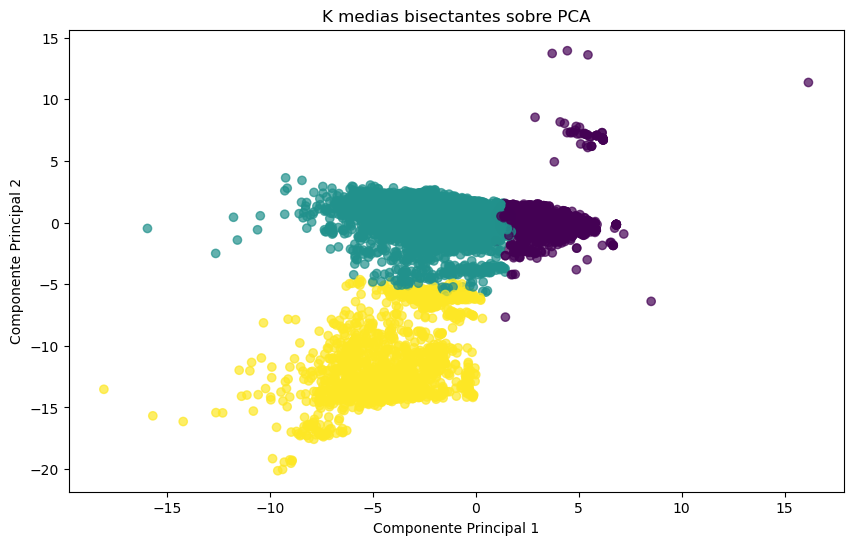

In [43]:
# Análisis de componentes principales para graficar los agrupamientos
pca = PCA(k=2, inputCol='features', outputCol='pcaFeatures')

pca_transformed = pca.fit(df_features).transform(df_features)

pca_result = np.array(pca_transformed.select('pcaFeatures').rdd.map(
    lambda x: x[0]).collect())
cluster_labels = np.array(bkm_predictions.select('prediction').rdd.flatMap(
    lambda x: x).collect())
plot_results(pca_result, cluster_labels, "K medias bisectantes sobre PCA",
    "Componente Principal 1", "Componente Principal 2")

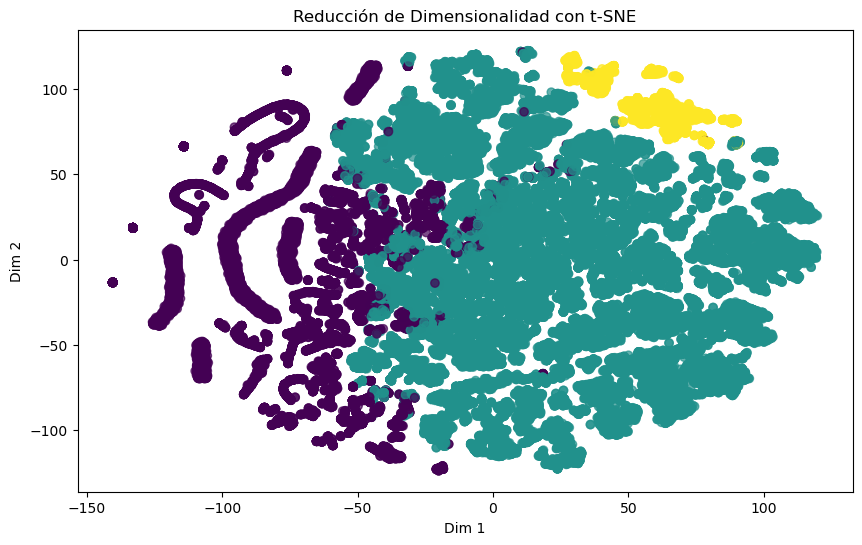

In [44]:
# Reducción de dimensionalidad con t-SNE
tsne_data = df_features.select(*feature_columns).toPandas()
tsne_result = TSNE(n_components=2, random_state=42).fit_transform(tsne_data)
plot_results(tsne_result, cluster_labels,
    "Reducción de Dimensionalidad con t-SNE", "Dim 1", "Dim 2")

In [49]:
# Convertir el DataFrame de Spark a Pandas
df_pandas = bkm_predictions.select('features', 'prediction').toPandas()

# Calcular el índice Silhouette
silhouette = silhouette_score(df_pandas['features'].tolist(),
    df_pandas['prediction'])
print(f"Índice Silhouette: {silhouette:.2f}")

Índice Silhouette: 0.35
